<a href="https://colab.research.google.com/github/nicolapitzalis/quick-pattern-recognition/blob/main/RBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Restricted Boltzmann Machines for Discriminative Tasks
In the following, we are going to implement a simple RBM architecture, to then exploit ist representative power to perform classification on the famous MNIST dataset.



## Preparation

### Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import struct
from sklearn.linear_model import LinearRegression, LogisticRegression

### Load the Dataset

In [ ]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

# Paths to the files
train_image_file = '/content/drive/MyDrive/datasets/mnist/train-images.idx3-ubyte'
train_label_file = '/content/drive/MyDrive/datasets/mnist/train-labels.idx1-ubyte'
test_image_file = '/content/drive/MyDrive/datasets/mnist/t10k-images.idx3-ubyte'
test_label_file = '/content/drive/MyDrive/datasets/mnist/t10k-labels.idx1-ubyte'

# Read the files
train_images = read_idx(train_image_file)
train_labels = read_idx(train_label_file)
test_images = read_idx(test_image_file)
test_labels = read_idx(test_label_file)

train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

## Implementing the RBM

In [ ]:
class RBM:

    def __init__(self, n_visible, n_hidden, learning_rate):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate

        # Initialize weights and biases
        self.weights = np.random.randn(n_visible, n_hidden) * 0.01
        self.bias_hidden = np.zeros(n_hidden)
        self.bias_visible = np.zeros(n_visible)

    def _logistic(self, x):
        return 1 / (1 + np.exp(-x))

    def sample_from_p(self, p):
        # Bernoulli sampling from a distribution p
        return (p > np.random.rand(*p.shape)).astype(np.float32)

    def sample_from_h(self, v):
        # Compute probabilities and sample hidden states
        p_h = self._logistic(np.dot(v, self.weights) + self.bias_hidden)
        sample_h = self.sample_from_p(p_h)
        return p_h, sample_h

    def sample_from_v(self, h):
        # Compute probabilities and sample visible states
        p_v = self._logistic(np.dot(h, self.weights.T) + self.bias_visible)
        sample_v = self.sample_from_p(p_v)
        return p_v, sample_v

    def cd_1(self, data, batch_size, max_epoch):
        num_samples = data.shape[0]

        for epoch in range(max_epoch):
            epoch_error = 0.0

            for i in range(0, num_samples, batch_size):
                # Get the batch
                v = data[i:i+batch_size]
                binary_v = self.sample_from_p(v)

                # Contrastive divergence
                p_h, sample_h = self.sample_from_h(binary_v)
                p_v, sample_v = self.sample_from_v(sample_h)
                p_h1, _ = self.sample_from_h(sample_v)

                # Compute the gradients
                positive_phase = np.dot(binary_v.T, p_h)
                negative_phase = np.dot(sample_v.T, p_h1)

                # Update weights and biases
                self.weights += self.learning_rate * (positive_phase - negative_phase) / batch_size
                self.bias_hidden += self.learning_rate * np.mean(p_h - p_h1, axis=0)
                self.bias_visible += self.learning_rate * np.mean(v - sample_v, axis=0)

                # Calculate error
                epoch_error += np.mean((binary_v - sample_v) ** 2)

            epoch_error /= num_samples
            print(f'Epoch: {epoch} \t Error: {epoch_error}')


## Training the RBM and Classification Task
Note that the images' matrices will be flattened into single vectors of 28x28 in order to feed the RBM.

### The classification Task
To understand whether our hidden representation is meaningful we choose very simple classifiers. For this reason, we explore both the linear regressor and the logistic regressor.

Also, given the balancing of both the training and test set, we'll use Accuracy as the performance measure.

In [ ]:
unique_classes, counts = np.unique(train_labels, return_counts=True)
print(dict(zip(unique_classes, counts)))

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


In [ ]:
unique_classes, counts = np.unique(test_labels, return_counts=True)
print(dict(zip(unique_classes, counts)))

{0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


### Training with 500 hidden units


In [ ]:
n_visible = 28 * 28  # Number of pixels in each image

In [ ]:
n_hidden = 500

rbm = RBM(n_visible, n_hidden, learning_rate=0.2)

# flatten the images
train_flattened_images = train_images.reshape(-1, 28*28)
test_flattened_images = test_images.reshape(-1, 28*28)

# train the RBM
rbm.cd_1(train_flattened_images, batch_size=64, max_epoch=10)

Epoch: 0 	 Error: 0.0012933510697757205
Epoch: 1 	 Error: 0.0009167726273338
Epoch: 2 	 Error: 0.0008279562616720795
Epoch: 3 	 Error: 0.0007828991954525312
Epoch: 4 	 Error: 0.0007543035188689828
Epoch: 5 	 Error: 0.0007362131969382365
Epoch: 6 	 Error: 0.0007230697944760323
Epoch: 7 	 Error: 0.0007116715819264452
Epoch: 8 	 Error: 0.0007039178757617871
Epoch: 9 	 Error: 0.0006973260791351398


Once the training has ended, we use the RBM to encode both the training and test set, in order to have a more powerful representation of the data that we'll use for the classification task.

### Encoding and Reconstruction
We'll have a look at what the reconstructed images look like using the trained RBM. For this, we will use some selected images from the test set.

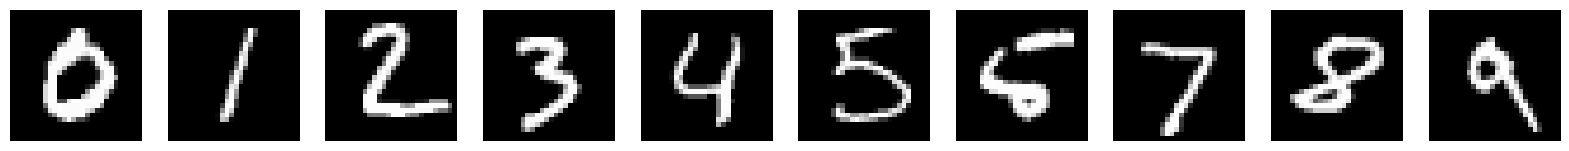

In [ ]:
og_images = []
og_images.append(test_flattened_images[3])
og_images.append(test_flattened_images[2])
og_images.append(test_flattened_images[1])
og_images.append(test_flattened_images[30])
og_images.append(test_flattened_images[4])
og_images.append(test_flattened_images[15])
og_images.append(test_flattened_images[8])
og_images.append(test_flattened_images[0])
og_images.append(test_flattened_images[61])
og_images.append(test_flattened_images[7])

reshaped_images = []
for im in og_images:
    reshaped_images.append(im.reshape(28, 28))

fig, axes = plt.subplots(nrows=1, ncols=len(reshaped_images), figsize=(20, 2))

for ax, image in zip(axes, reshaped_images):
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.show()

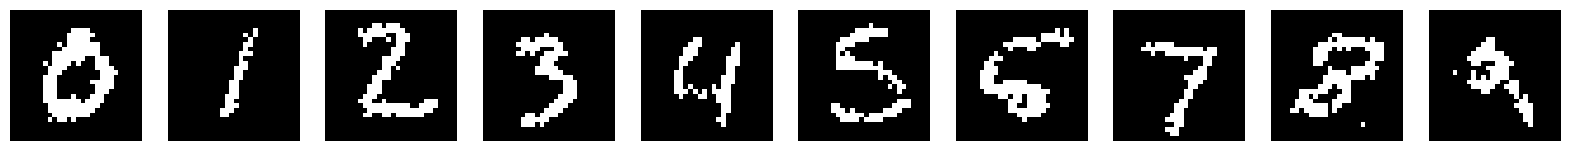

In [ ]:
recon_images = []

for im in og_images:
    bin_image = rbm.sample_from_p(im)
    _, sample_h = rbm.sample_from_h(bin_image)
    _, sample_v = rbm.sample_from_v(sample_h)
    recon_images.append(sample_v.astype(int).reshape(28, 28))

fig, axes = plt.subplots(nrows=1, ncols=len(recon_images), figsize=(20, 2))

for ax, image in zip(axes, recon_images):
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.show()

Now the entire training and test sets will be encoded to train our classifier.

In [ ]:
encoded_X = []

for x in train_flattened_images:
    binary_x = rbm.sample_from_p(x)
    encoded_X.append(rbm.sample_from_h(binary_x)[1])

X_train = np.array(encoded_X)
y_train = train_labels

In [ ]:
encoded_X = []

for x in test_flattened_images:
    binary_x = rbm.sample_from_p(x)
    encoded_X.append(rbm.sample_from_h(binary_x)[1])

X_test = np.array(encoded_X)
y_test = test_labels

### Regression

In [ ]:
clf = LinearRegression().fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

0.7008094215724834

As one could expect, a linear regressor does not perform magnificently on the classification task at end, but still the results are not bad at all.

In [ ]:
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial').fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

0.9286

The logistic regressor performs way better than the linear one, achieving an interesting performance result.

## More Experiments
In the following we'll explore some more configurations of hyperparameters, especially the number of the hidden neurons.

### Training with 100 hidden units

In [ ]:
n_hidden = 100

rbm = RBM(n_visible, n_hidden, learning_rate=0.2)

# Flatten the images
train_flattened_images = train_images.reshape(-1, 28*28)
test_flattened_images = test_images.reshape(-1, 28*28)

# Train the RBM
rbm.cd_1(train_flattened_images, batch_size=64, max_epoch=10)

Epoch: 0 	 Error: 0.0015835103768855334
Epoch: 1 	 Error: 0.0012063934958850345
Epoch: 2 	 Error: 0.0011230219629282752
Epoch: 3 	 Error: 0.001076966742426157
Epoch: 4 	 Error: 0.001047032445607086
Epoch: 5 	 Error: 0.0010266302625338236
Epoch: 6 	 Error: 0.001009988507380088
Epoch: 7 	 Error: 0.000999493782967329
Epoch: 8 	 Error: 0.000991240167617798
Epoch: 9 	 Error: 0.0009840342015028


### Encoding and Reconstruction


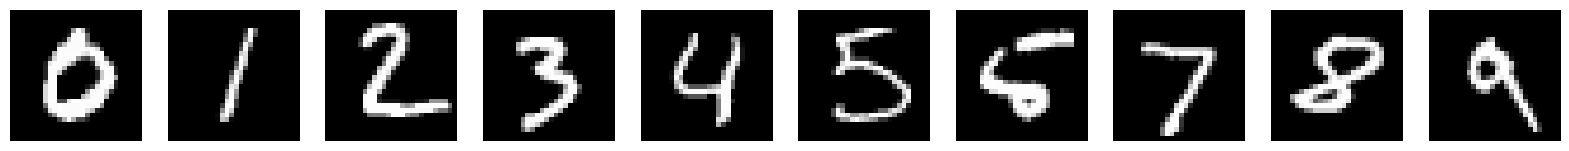

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(reshaped_images), figsize=(20, 2))

for ax, image in zip(axes, reshaped_images):
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.show()

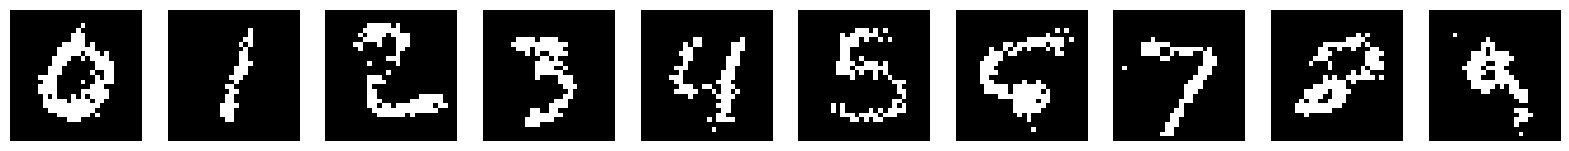

In [ ]:
recon_images = []

for im in og_images:
    bin_image = rbm.sample_from_p(im)
    _, sample_h = rbm.sample_from_h(bin_image)
    _, sample_v = rbm.sample_from_v(sample_h)
    recon_images.append(sample_v.astype(int).reshape(28, 28))

fig, axes = plt.subplots(nrows=1, ncols=len(recon_images), figsize=(20, 2))

for ax, image in zip(axes, recon_images):
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.show()

Even thoug the accuracy did not change too much, we can see how the reconstructed images are a bit less clear than those produced by the RBM trained on 500 hidden units.

In [ ]:
encoded_X = []

for x in train_flattened_images:
    binary_x = rbm.sample_from_p(x)
    encoded_X.append(rbm.sample_from_h(x)[1])

X_train = np.array(encoded_X)
y_train = train_labels

In [ ]:
encoded_X = []

for x in test_flattened_images:
    binary_x = rbm.sample_from_p(x)
    encoded_X.append(rbm.sample_from_h(x)[1])

X_test = np.array(encoded_X)
y_test = test_labels

### Regression

In [ ]:
clf = LinearRegression().fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

0.6464804501076176

In [ ]:
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial').fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

0.9176

As we can observe, decreasing the number of hidden neurons up to 100 (from the initial 500) does not pertain a significant decrease in the accuracy score of the classifier.
For this reason, we'll also explore a smaller RBM od 30 units.

### Training with 30 hidden units

In [ ]:
n_visible = 28 * 28  # Number of pixels in each image
n_hidden = 30

rbm = RBM(n_visible, n_hidden, learning_rate=0.2)

# Flatten the images
train_flattened_images = train_images.reshape(-1, 28*28)
test_flattened_images = test_images.reshape(-1, 28*28)

# Train the RBM
rbm.cd_1(train_flattened_images, batch_size=64, max_epoch=10)

Epoch: 0 	 Error: 0.0019400437125315269
Epoch: 1 	 Error: 0.0016281568873673677
Epoch: 2 	 Error: 0.0015851705348740022
Epoch: 3 	 Error: 0.0015656768180429936
Epoch: 4 	 Error: 0.001556596447651585
Epoch: 5 	 Error: 0.0015496871011952558
Epoch: 6 	 Error: 0.0015444438902040322
Epoch: 7 	 Error: 0.0015382702884574732
Epoch: 8 	 Error: 0.0015300518836826086
Epoch: 9 	 Error: 0.0015248893909156323


Also notice that 10 epochs seem to be enough since the error isn't really decreasing (probably given the huge number of batches processed at each epoch)

### Encoding and Reconstruction


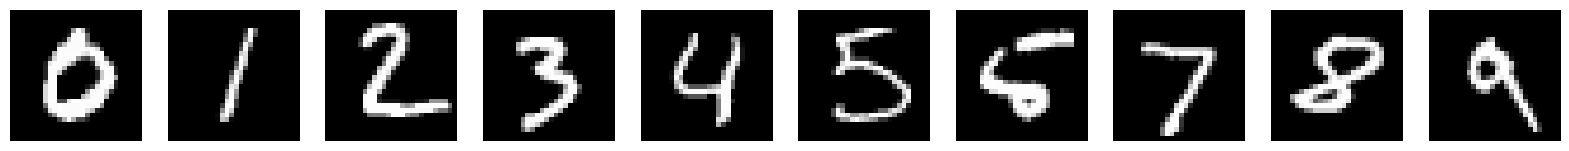

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(reshaped_images), figsize=(20, 2))

for ax, image in zip(axes, reshaped_images):
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.show()

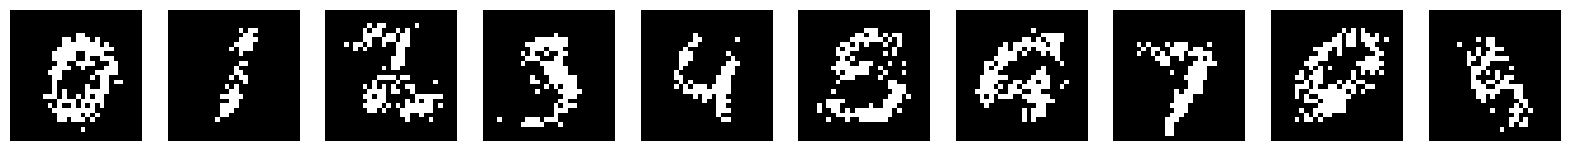

In [ ]:
recon_images = []

for im in og_images:
    bin_image = rbm.sample_from_p(im)
    _, sample_h = rbm.sample_from_h(bin_image)
    _, sample_v = rbm.sample_from_v(sample_h)
    recon_images.append(sample_v.astype(int).reshape(28, 28))

fig, axes = plt.subplots(nrows=1, ncols=len(recon_images), figsize=(20, 2))

for ax, image in zip(axes, recon_images):
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.show()

As we can see, the reconstruction isn't really too precise using only 30 hidden units.

In [ ]:
encoded_X = []

for x in train_flattened_images:
    binary_x = rbm.sample_from_p(x)
    encoded_X.append(rbm.sample_from_h(x)[1])

X_train = np.array(encoded_X)
y_train = train_labels

In [ ]:
encoded_X = []

for x in test_flattened_images:
    binary_x = rbm.sample_from_p(x)
    encoded_X.append(rbm.sample_from_h(x)[1])

X_test = np.array(encoded_X)
y_test = test_labels

### Regression

In [ ]:
clf = LinearRegression().fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

0.5572406751964744

In [ ]:
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial').fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

0.8603

Using 30 hidden neurons seems to underperform quite noticeably w.r.t. the 100-neurons RBM.